In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Embedding,Activation,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPooling1D,LSTM
from tensorflow.keras.optimizers import Adam

import re
import numpy as np
from numpy import array
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

In [2]:
abbreviations ={
    "’": "'",
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause'": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'am": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shalln't": "shall not",
    "shan't": "shall not",
    "shan't've": "shall not have",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "he is",
    "shouldn've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there'is": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "were't": "were not",
    " u ": "you",
    " ur ": "your",
    "you’re": "you are",
    "you're": "you are",
    " u'r ": "you are",
    " n ": "and",
    " lil mor ": "little more",
    " can' ": "cannot",
    " gov re ": "government regulations",
    " yea ": " yes ",
    " yeah ": " yes ",    
}

In [3]:
indomain= pd.read_csv('./datasets/indomain.csv', encoding='utf8') #onlyTweets
indomain.head()

,tweet,subjectivity
0,@VancityReynolds @vincenzolandino @007 does Ca...,subjective
1,@VancityReynolds @vincenzolandino @007 ????yea...,subjective
2,@VancityReynolds @vincenzolandino @007 We all ...,subjective
3,@VancityReynolds @vincenzolandino @007 You wou...,subjective
4,HE LOOKS LIKE AN AGENT OR KINGSMAN TYPE OF SHI...,subjective


In [4]:
outdomain= pd.read_csv('./datasets/outdomain.csv',sep=',', encoding='utf-8') #onlyTweets
outdomain.head()

,tweet,subjectivity,ts,actual
0,Oh right but if you're one of those absolute w...,subjective,y,subjective
1,I ate the squid game burger. https://t.co/wqV...,objective,y,objective
2,It was 5011 million Squid Games costumes and p...,subjective,y,subjective
3,"If you enjoyed squid game, you should definite...",subjective,y,subjective
4,Social inequality and hyper violence: why the ...,objective,y,objective


### Translating emojis

In [5]:
with open('./dictionaries/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()) +' emojihasbeendetected ', text)
    return text

In [6]:
indomain["tweet"]=indomain["tweet"].apply(convert_emojis_to_word)
indomain["tweet"]
# time 1m11.8s

0      @VancityReynolds @vincenzolandino @007 does Ca...
1      @VancityReynolds @vincenzolandino @007 ????yea...
2      @VancityReynolds @vincenzolandino @007 We all ...
3      @VancityReynolds @vincenzolandino @007 You wou...
4      HE LOOKS LIKE AN AGENT OR KINGSMAN TYPE OF SHI...
                             ...                        
839    Police officers who guard Downing Street have ...
840    A jury has criticised police and prosecutors a...
841    Former model Katie Price faces a possible pris...
842    Nearly two thirds of the public back the aboli...
843    Deputy Prime Minister Dominic Raab said on Sun...
Name: tweet, Length: 844, dtype: object

In [7]:
outdomain["tweet"]=outdomain["tweet"].apply(convert_emojis_to_word)
outdomain["tweet"]
# time 56.8s 

0      Oh right but if you're one of those absolute w...
1      I ate the squid game burger.  https://t.co/wqV...
2      It was 5011 million Squid Games costumes and p...
3      If you enjoyed squid game, you should definite...
4      Social inequality and hyper violence: why the ...
                             ...                        
665     @CristianoXtra_ Uneducated Admin, This is 202...
666    Lionel Messi said Lewandowski deserves the Bal...
667    FIFA Club World Cup in 2020 and he's won the C...
668    Li Tie was appointed as the China national hea...
669    My top 5 last games i played are  1  FIFA 2021...
Name: tweet, Length: 670, dtype: object

### Preprocessing function

In [8]:
import string
import re
def cleanTweets(tweet):
    tweet= re.sub(r'@[A-Za-z0-9]+','',tweet)                            #remove @mentions;r-> the expression is a raw string,+ -> one char or more
    tweet= re.sub(r'#','',tweet)                                        #remove '#' Symbol
    # tweet= re.sub(r'RT[\s]+','',tweet)                                  #remove RT
    tweet= re.sub(r'https?:\/\/\S+','websiteisgiven',tweet)             #replace hyper links
    # tweet= tweet.lower()                                                #convert to lowercase
    # tweet= re.sub(r'\d+', '', tweet)                                    #remove numbers (DON'T activate it if numbers in text are relevant)
    translator = str.maketrans('', '', string.punctuation)
    tweet= tweet.translate(translator)                                  #remove punctuations
    # tweet = re.sub(r"[!\"#$%&'()*+,\-/:;<=>@[\]^_`{|}~]", '', tweet)
    return tweet

In [9]:
%%time
indomain['tweet']= indomain['tweet'].apply(lambda txt:cleanTweets(txt))
print(indomain['tweet'])

0         does Canada have its own spy agency lol the...
1                       yea I dont want ya as James Bond
2         We all love Ryan but hes Canadian and inste...
3         You woud make a great James Bond but you wo...
4      HE LOOKS LIKE AN AGENT OR KINGSMAN TYPE OF SHI...
                             ...                        
839    Police officers who guard Downing Street have ...
840    A jury has criticised police and prosecutors a...
841    Former model Katie Price faces a possible pris...
842    Nearly two thirds of the public back the aboli...
843    Deputy Prime Minister Dominic Raab said on Sun...
Name: tweet, Length: 844, dtype: object
CPU times: total: 15.6 ms
Wall time: 5 ms


In [10]:
%%time
outdomain['tweet']= outdomain['tweet'].apply(lambda txt:cleanTweets(txt))
print(outdomain['tweet'])

0      Oh right but if youre one of those absolute we...
1            I ate the squid game burger  websiteisgiven
2      It was 5011 million Squid Games costumes and p...
3      If you enjoyed squid game you should definitel...
4      Social inequality and hyper violence why the b...
                             ...                        
665      Uneducated Admin This is 2020 FIFA The Best ...
666    Lionel Messi said Lewandowski deserves the Bal...
667    FIFA Club World Cup in 2020 and hes won the CA...
668    Li Tie was appointed as the China national hea...
669    My top 5 last games i played are  1  FIFA 2021...
Name: tweet, Length: 670, dtype: object
CPU times: total: 0 ns
Wall time: 6 ms


In [11]:
import re
inText=' '.join(indomain['tweet'])
inText=inText.split()
inFreqComm= pd.Series(inText).value_counts()
inRare=inFreqComm[inFreqComm.values==1] # get words that have been occured a single time to be removed from dataset

def getCleanTextIn(txt):
    if type(txt) is str:
        txt=txt.lower()
        for key in abbreviations:                                                   #transform abbreviations into complete words
            value = abbreviations[key]
            txt=txt.replace(key, value)
#         # txt=re.sub(r'[A-Za-z0-9+._-]+@[A-Za-z0-9+._-]+\.[A-Za-z0-9+._-]+','',txt)   #remove emails
#         txt= re.sub(r'@[A-Za-z0-9]+','',txt)                                        #remove @mentions;r-> the expression is a raw string,+ -> one char or more
#         txt= re.sub(r'#','',txt)                                                    #remove '#' Symbol
#         txt= re.sub(r'RT[\s]+','',txt)                                              #remove RT
#         txt= re.sub(r'https?:\/\/\S+','websiteisgiven',txt)                         #transform all hyper links to keys
#         # txt=re.sub('[^A-Z a-z]+','',txt)                                            #keep only charecters
        # txt=' '.join([term for term in txt.split() if term not in rare])            #keep only frequent words/ neglect once occured words
        return txt
    else:
        return txt

## Translator

In [12]:
# from deep_translator import GoogleTranslator

# translated1=[]
# for i in indomain['tweet']:
#     translated1.append(GoogleTranslator(source='auto', target='de').translate(i))
# translated1

# # time 19m37.1s

# # to_translate = 'I want to translate this text'
# # translated = GoogleTranslator(source='auto', target='de').translate(to_translate)
# # outpout -> Ich möchte diesen Text übersetzen

In [13]:
# %%time
# translated=[]
# for i in translated1:
#     translated.append(GoogleTranslator(source='auto', target='en').translate(i))
# translated

# # time: 11min 15.4s

In [14]:
# tweets=indomain["tweet"].tolist()
# type(tweets)
# tweets=tweets+translated
# tweets

### Write translated to text file

In [15]:
# textfile = open("./translated/listFlie.txt", "w",encoding="utf-8")
# for element in tweets:
#     textfile.write(element + "\n")
# textfile.close()

### End of translation configuration

### Read translated from text file

In [16]:
#Make sure to remove last empty line from listFile.txt before run this snippet
my_file = open("./translated/listFlie.txt", "r",encoding="utf-8",newline="\r\n")
listText = my_file.read().split("\r\n")
# listText

In [17]:
translatedList= pd.Series(listText)
translatedList
start=len(indomain['tweet'])
translatedList=translatedList[start:len(translatedList)]
translatedList

844     Does Canada have its own spy agency lol they s...
845                   Yes, I don't want you as James Bond
846     We all love Ryan but he is Canadian and instea...
847     You'd make a great James Bond, but you'd have ...
848     HE LOOKS LIKE AN AGENT OR KINGSMAN TYPE OF SHI...
                              ...                        
1683    Police officers guarding Downing Street were i...
1684    A jury has criticized police and prosecutors a...
1685    Former model Katie Price faces possible jail t...
1686    Almost two-thirds of the public supports scrap...
1687    Deputy Prime Minister Dominic Raab said on Sun...
Length: 844, dtype: object

In [18]:
# type(translatedList)

## End of translation

### Text cleaning

In [19]:
ouText=' '.join(outdomain['tweet'])
ouText=ouText.split()
outFreqComm= pd.Series(ouText).value_counts()
outRare=outFreqComm[outFreqComm.values==1] # get words that have been occured a single time to be removed from dataset

def getCleanTextOut(txt):
    if type(txt) is str:
        txt=txt.lower()
        for key in abbreviations:                                                   #transform abbreviations into complete words
            value = abbreviations[key]
            txt=txt.replace(key, value)
#         # txt=re.sub(r'[A-Za-z0-9+._-]+@[A-Za-z0-9+._-]+\.[A-Za-z0-9+._-]+','',txt)   #remove emails
#         txt= re.sub(r'@[A-Za-z0-9]+','',txt)                                        #remove @mentions;r-> the expression is a raw string,+ -> one char or more
#         txt= re.sub(r'#','',txt)                                                    #remove '#' Symbol
#         txt= re.sub(r'RT[\s]+','',txt)                                              #remove RT
#         txt= re.sub(r'https?:\/\/\S+','websiteisgiven',txt)                         #transform all hyper links to keys
#         txt=re.sub('[^A-Z a-z]+','',txt)                                            #keep only charecters
#         txt=' '.join([term for term in txt.split() if term not in rare])            #keep only frequent words/ neglect once occured words
        return txt
    else:
        return txt

In [20]:
# %%time
# tweets= tweets.apply(lambda txt:getCleanTextIn(txt))
# print(tweets)

In [21]:
%%time
indomain['tweet']= indomain['tweet'].apply(lambda txt:getCleanTextIn(txt))
print(indomain['tweet'])

0         does canada have its own spy agency lol the...
1                       yes i dont want ya as james bond
2         we all love ryan but hes canadian and inste...
3         you woud make a great james bond but you wo...
4      he looks like an agent or kingsman type of shi...
                             ...                        
839    police officers who guard downing street have ...
840    a jury has criticised police and prosecutors a...
841    former model katie price faces a possible pris...
842    nearly two thirds of the public back the aboli...
843    deputy prime minister dominic raab said on sun...
Name: tweet, Length: 844, dtype: object
CPU times: total: 15.6 ms
Wall time: 12 ms


In [22]:
%%time
outdomain['tweet']= outdomain['tweet'].apply(lambda txt:getCleanTextOut(txt))
print(outdomain['tweet'])

0      oh right but if youre one of those absolute we...
1            i ate the squid game burger  websiteisgiven
2      it was 5011 million squid games costumes and p...
3      if you enjoyed squid game you should definitel...
4      social inequality and hyper violence why the b...
                             ...                        
665      uneducated admin this is 2020 fifa the best ...
666    lionel messi said lewandowski deserves the bal...
667    fifa club world cup in 2020 and hes won the ca...
668    li tie was appointed as the china national hea...
669    my top 5 last games i played are  1  fifa 2021...
Name: tweet, Length: 670, dtype: object
CPU times: total: 15.6 ms
Wall time: 12 ms


### Cleaning translated

In [23]:
translatedList= translatedList.apply(lambda txt:cleanTweets(txt))
translatedList

844     Does Canada have its own spy agency lol they s...
845                     Yes I dont want you as James Bond
846     We all love Ryan but he is Canadian and instea...
847     Youd make a great James Bond but youd have to ...
848     HE LOOKS LIKE AN AGENT OR KINGSMAN TYPE OF SHI...
                              ...                        
1683    Police officers guarding Downing Street were i...
1684    A jury has criticized police and prosecutors a...
1685    Former model Katie Price faces possible jail t...
1686    Almost twothirds of the public supports scrapp...
1687    Deputy Prime Minister Dominic Raab said on Sun...
Length: 844, dtype: object

In [24]:
%%time
translatedList= translatedList.apply(lambda txt:getCleanTextIn(txt))
translatedList

CPU times: total: 15.6 ms
Wall time: 11 ms


844     does canada have its own spy agency lol they s...
845                     yes i dont want you as james bond
846     we all love ryan but he is canadian and instea...
847     youd make a great james bond but youd have to ...
848     he looks like an agent or kingsman type of shi...
                              ...                        
1683    police officers guarding downing street were i...
1684    a jury has criticized police and prosecutors a...
1685    former model katie price faces possible jail t...
1686    almost twothirds of the public supports scrapp...
1687    deputy prime minister dominic raab said on sun...
Length: 844, dtype: object

#### Numerizing target values

In [25]:
indomain['subjectivity'].value_counts()

objective     433
subjective    411
Name: subjectivity, dtype: int64

In [26]:
outdomain['subjectivity'].value_counts()

subjective    466
objective     204
Name: subjectivity, dtype: int64

In [29]:
inText = indomain['tweet'].tolist()   #convert series to list
print('rows are: ',len(inText))
print('columns are: ',len(inText[0]))
inText[:3]                            #show 3 lines

rows are:  844
columns are:  158


['   does canada have its own spy agency lol they send him undercover to stop the japanese mafia from selling imitation canadian bacon in a hot fuzz style movie',
 '   yes i dont want ya as james bond',
 '   we all love ryan but hes canadian and instead of killing the baddie he would try to talk them down by being nice']

## Concat translated to original

In [30]:
translatedList=translatedList.tolist()
translatedList

['does canada have its own spy agency lol they send him undercover to stop the japanese mafia from selling imitation canadian bacon in a hot fuzz style movie',
 'yes i dont want you as james bond',
 'we all love ryan but he is canadian and instead of killing the bad guy he would try to calm her down by being nice',
 'youd make a great james bond but youd have to swap the gin for a martini',
 'he looks like an agent or kingsman type of shit in 2nd go james bond go james bond go go go go',
 'i agree with ryan reynolds i like the tradition of having english actors play bond and a really controversial actor is someone like idris alba its time',
 'disappointed in the new jamesbond movie its like they killed the franchise',
 'james bond dies at the end of the film last line in the credits',
 'saw the latest james bond film at this fantastic cinema last weekend art direction and styling rud',
 'beautiful photo',
 'has anyone ever set a timer on their amazon alexa for 6 minutes only to end it 

## Add back-translated to original

In [31]:
flag=0
text1=inText
len(text1)

844

In [32]:
if flag ==0:
    text1= inText+translatedList
    flag+=1

text= text1
print(len(text))
text

1688


['   does canada have its own spy agency lol they send him undercover to stop the japanese mafia from selling imitation canadian bacon in a hot fuzz style movie',
 '   yes i dont want ya as james bond',
 '   we all love ryan but hes canadian and instead of killing the baddie he would try to talk them down by being nice',
 '   you woud make a great james bond but you would have to change the gin for martini',
 'he looks like an agent or kingsman type of shit in 2nd go james bond go james bond go go go go',
 '   i agree with ryan reynolds i like the tradition of having english actors play bond and a truly controversial actor is someone like idris alba its time',
 'disappointed with the new jamesbond movie its like they killed the franchise',
 ' james bond dies at the end of the movie last line in the credits',
 'watched the latest last james bond movie at this amazing cinema  last weekend    art direction and styling rud  hair and makeup   models official      websiteisgiven',
 '   beaut

### Shuffle text

In [33]:
# import random
# shuff=text
# twtShuffle=[]

# def scramble(sentence):
#    split = sentence.split()  # Split the string into a list of words
#    random.shuffle(split)  # This shuffles the list in-place.
#    return ' '.join(split)  # Turn the list back into a string

# row=0
# col=0
# for i in shuff:
#    row +=1
#    col = row
#    for j in i:
#       if row == col:
#          twtShuffle.append(scramble(i))
#          col +=1

# print(type(twtShuffle))
# print('rows are: ',len(twtShuffle))
# print('columns are: ',len(twtShuffle[0]))
# # print(twtShuffle)
# print(row)
# print(col)

# # textfile = open("shuffleList.txt", "w",encoding="utf-8")
# # for element in twtShuffle:
# #     textfile.write(element + "\n")
# # textfile.close()

In [34]:
# text= text+twtShuffle
# text

### End shuffling

In [35]:
ouText = outdomain['tweet'].tolist()   #convert series to list
ouText[16:17]                            #show 3 lines

['  poor lil man loudlycryingface emojihasbeendetected loudlycryingface emojihasbeendetected loudlycryingface emojihasbeendetected  let him get some sleep bro']

In [36]:
indomain["subjectivity"] = indomain["subjectivity"].astype('category')
target = indomain['subjectivity'].cat.codes
target = pd.concat([target]*2, ignore_index=True) #repeat target values *x times
# type(target)
target

0       1
1       1
2       1
3       1
4       1
       ..
1683    0
1684    0
1685    0
1686    0
1687    0
Length: 1688, dtype: int8

## Activate next snippet only when text shuffling

In [37]:
# target = pd.concat([target]*2, ignore_index=True) #repeat target values *x times
# # type(target)
# target

In [38]:
outdomain["subjectivity"] = outdomain["actual"].astype('category')
ouTarget = outdomain['subjectivity'].cat.codes

In [39]:
token = Tokenizer()
token.fit_on_texts(text)

In [40]:
vocabSize = len(token.word_index) + 1
vocabSize #2903 - 4276 vocabularies/ with back translated 3288-4794

4794

In [41]:
# print(token.word_index) #how vocabs have been indexed

In [42]:
encodedText = token.texts_to_sequences(text)
print(encodedText[:3])
print('rows are: ',len(encodedText))
print('columns are: ',len(encodedText[0]))

[[212, 1322, 16, 30, 495, 315, 854, 130, 46, 855, 90, 1595, 3, 316, 1, 1596, 1597, 22, 1323, 856, 110, 1598, 5, 2, 253, 1599, 358, 27], [68, 8, 58, 166, 1600, 15, 12, 10], [39, 65, 91, 70, 28, 254, 110, 6, 728, 4, 496, 1, 3686, 42, 51, 564, 3, 1601, 92, 233, 32, 120, 234]]
rows are:  1688
columns are:  28


### Make training input equal in size

In [43]:
maxLength = 100 # make all rows equal in size
fixed = pad_sequences(encodedText,maxlen=maxLength,padding='pre') # could be configured as padding= 'post'
print(fixed)

[[   0    0    0 ... 1599  358   27]
 [   0    0    0 ...   15   12   10]
 [   0    0    0 ...   32  120  234]
 ...
 [   0    0    0 ...   74 4791 3652]
 [   0    0    0 ...  846   21  119]
 [   0    0    0 ...    1 1062 1555]]


In [44]:
fixed.shape

(1688, 100)

# 'GloVe' Vectors

In [45]:
GloveVectors = dict()

In [46]:
%%time
# file = open('gloveTwitter/glove.twitter.27B.200d.txt', encoding='utf-8')
# file = open('gloveTwitter/glove.840B.300d.txt', encoding='utf-8')
file = open('dictionaries/gloveTwitter/glove.6B.300d.txt', encoding='utf-8')

for line in file:
    values = line.split()
    word = values[0]                    # to skip the first element which is a word 
    vectors = np.asarray(values[1:])    # to start from the numbers that are located after the word
    GloveVectors[word] = vectors
file.close()

CPU times: total: 21.7 s
Wall time: 21.7 s


In [47]:
len(GloveVectors.keys())    #number of keys for twitter GloVe 1193514/ for 300giga vector 400000/ glove.840B.300d 2195884

400000

In [48]:
# wordVectorMatrix=np.zeros((vocabSize, 200)) # each word at vocab, should have 200 more dimentsion
wordVectorMatrix=np.zeros((vocabSize, 300)) # each word at vocab, should have 300 more dimentsion

currentWord=0
new_Words=0
for word, index in token.word_index.items():
    vector= GloveVectors.get(word)
    if vector is not None:
        currentWord += 1
        wordVectorMatrix[index] = vector
    else:
        new_Words +=1
print('number of words found in GloVe: ',currentWord)   #number of words found in GloVe:  2654-3908  / back translated 3004-4384
print('number of words out of GloVe: ',new_Words)       #number of words out of GloVe:  249-367     / back translated 283-409

number of words found in GloVe:  4384
number of words out of GloVe:  409


### TF2.0 and Keras Model Building

In [49]:
X_train, X_tset, Y_train, Y_test = train_test_split(fixed, target, random_state=42, test_size= 0.215, shuffle=True,stratify=target)

# CNN-Model

In [50]:
# vecSize = 200
vecSize = 300

model = Sequential()
model.add(Embedding(vocabSize, vecSize, input_length = maxLength, weights = [wordVectorMatrix], trainable = False))

model.add(Conv1D(50, 8, activation='relu'))
model.add(MaxPooling1D(5))

# model.add(Dense(32, activation='relu'))

# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.01))

model.add(GlobalMaxPooling1D())
model.add(Dropout(0.35))

model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.55))

model.compile(optimizer=Adam(learning_rate=0.001), loss= 'binary_crossentropy', metrics=['accuracy'])

print(model.summary())
model.fit(X_train, Y_train, epochs=160,batch_size=2, validation_data=(X_tset, Y_test))
# history=model.fit(X_train, Y_train, epochs=128,batch_size=16, validation_data=(X_tset, Y_test))

#time 2m 22.7s


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          1438200   
                                                                 
 conv1d (Conv1D)             (None, 93, 50)            120050    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 50)           0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

663/663 [==============================] - 2s 3ms/step - loss: 4.2534 - accuracy: 0.7162 - val_loss: 0.3869 - val_accuracy: 0.8512
Epoch 48/160
663/663 [==============================] - 2s 3ms/step - loss: 4.3237 - accuracy: 0.7170 - val_loss: 0.3586 - val_accuracy: 0.8485
Epoch 49/160
663/663 [==============================] - 2s 3ms/step - loss: 4.4859 - accuracy: 0.6996 - val_loss: 0.3366 - val_accuracy: 0.8457
Epoch 50/160
663/663 [==============================] - 2s 3ms/step - loss: 4.1772 - accuracy: 0.7238 - val_loss: 0.3277 - val_accuracy: 0.8430
Epoch 51/160
663/663 [==============================] - 2s 3ms/step - loss: 4.5582 - accuracy: 0.6981 - val_loss: 0.3350 - val_accuracy: 0.8430
Epoch 52/160
663/663 [==============================] - 2s 3ms/step - loss: 4.2237 - accuracy: 0.7208 - val_loss: 0.3372 - val_accuracy: 0.8457
Epoch 53/160
663/663 [==============================] - 2s 3ms/step - loss: 4.1019 - accuracy: 0.7298 - val_loss: 0.3437 - val_accuracy: 0.8457
Epoch

Epoch 104/160
663/663 [==============================] - 1s 2ms/step - loss: 4.3816 - accuracy: 0.7109 - val_loss: 0.5094 - val_accuracy: 0.8430
Epoch 105/160
663/663 [==============================] - 1s 2ms/step - loss: 4.6557 - accuracy: 0.6906 - val_loss: 0.4768 - val_accuracy: 0.8402
Epoch 106/160
663/663 [==============================] - 1s 2ms/step - loss: 4.1864 - accuracy: 0.7223 - val_loss: 0.4830 - val_accuracy: 0.8485
Epoch 107/160
663/663 [==============================] - 1s 2ms/step - loss: 4.3275 - accuracy: 0.7125 - val_loss: 0.4577 - val_accuracy: 0.8457
Epoch 108/160
663/663 [==============================] - 1s 2ms/step - loss: 4.2791 - accuracy: 0.7170 - val_loss: 0.4556 - val_accuracy: 0.8402
Epoch 109/160
663/663 [==============================] - 1s 2ms/step - loss: 4.1192 - accuracy: 0.7253 - val_loss: 0.4767 - val_accuracy: 0.8430
Epoch 110/160
663/663 [==============================] - 1s 2ms/step - loss: 4.3674 - accuracy: 0.7125 - val_loss: 0.4730 - val_ac

663/663 [==============================] - 2s 2ms/step - loss: 4.1096 - accuracy: 0.7306 - val_loss: 0.5565 - val_accuracy: 0.8347


# LSTM-Model

In [51]:
# %%time
# vecSize = 300
# Y_train=pd.get_dummies(Y_train)
# Y_test=pd.get_dummies(Y_test)
# target=pd.get_dummies(target)
# ouTarget=pd.get_dummies(ouTarget)
# n_categories=2

# model = Sequential()

# # Keras Embedding layer with Word2Vec weights initialization
# model.add(Embedding(input_dim=vocabSize,
#                     output_dim=vecSize,
#                     weights=[wordVectorMatrix],
#                     input_length=maxLength,
#                     mask_zero=True,
#                     trainable=False))
# # print(w2v_weights.shape)
# model.add(LSTM(20, dropout=0.4, activation='tanh', recurrent_dropout=0.4))
# # # model.add(Flatten())
# model.add(Dense(n_categories,activation='sigmoid'))
# model.add(Dropout(0.55))

# model.add(Activation('softmax'))
# model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) #sparse_categorical_crossentropy
# print(model.summary())

# # model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_data=(X_tset, Y_test), verbose=1) 
# model.fit(X_train, Y_train, epochs=64, batch_size=16, validation_data=(X_tset, Y_test), verbose=1) 
# # print(w2v_weights)

# #time: 10min 50.1s

In [52]:
# history = model.fit(X_train, Y_train, epochs=128,batch_size=16, validation_data=(X_tset, Y_test))

## Plotting Loss and Accuracy Graphs

In [53]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 12))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Loss')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.figure(figsize=(12, 12))
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Accuracy')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# in-domain evaluation

In [54]:
from sklearn.metrics import classification_report
testPredict= (model.predict(fixed) > 0.5).astype("int32")
# testPredict

In [55]:
print ('in-domain \n',classification_report(testPredict, target))

in-domain 
               precision    recall  f1-score   support

           0       0.95      0.85      0.90       975
           1       0.82      0.94      0.87       713

    accuracy                           0.89      1688
   macro avg       0.88      0.89      0.88      1688
weighted avg       0.89      0.89      0.89      1688



# Save model

In [56]:
# save
# model.save("cnnGlove1")

In [57]:
from keras.models import load_model
cnnGlove=load_model('cnnGlove')

# Predict out-domain

In [58]:
encodedOuText = token.texts_to_sequences(ouText)
# print(encodedOuText[17:19])
# print(encodedOuText)
# print(ouText)

In [59]:
maxLength = 100 # make all rows equal in size
outFixed = pad_sequences(encodedOuText,maxlen=maxLength,padding='pre') # could be configured as padding= 'post'
print(outFixed)

[[   0    0    0 ...   22 1500  130]
 [   0    0    0 ... 4632  335   37]
 [   0    0    0 ...   41   69   36]
 ...
 [   0    0    0 ...  823    5 2483]
 [   0    0    0 ...  205 2048   37]
 [   0    0    0 ...    8  239    6]]


In [60]:
outFixed.shape

(670, 100)

In [61]:
testPredict= (model.predict(outFixed) > 0.5).astype("int32")
print ('out-domain \n',classification_report(testPredict, ouTarget))


out-domain 
               precision    recall  f1-score   support

           0       0.62      0.52      0.57       240
           1       0.75      0.82      0.79       430

    accuracy                           0.71       670
   macro avg       0.69      0.67      0.68       670
weighted avg       0.71      0.71      0.71       670



In [62]:
testPredict= (cnnGlove.predict(outFixed) > 0.5).astype("int32")
print ('out-domain \n',classification_report(testPredict, ouTarget))


out-domain 
               precision    recall  f1-score   support

           0       0.63      0.57      0.60       226
           1       0.79      0.83      0.81       444

    accuracy                           0.74       670
   macro avg       0.71      0.70      0.70       670
weighted avg       0.74      0.74      0.74       670



# Clustering

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
#Libraries for clustering
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [64]:
vectorizerTf = TfidfVectorizer(stop_words='english')
vectorizerNtf = TfidfVectorizer(stop_words='english',analyzer='word',ngram_range=(1,2))  
                                                                    #TF-IDF (n-gram level)// 
                                                                    #consider n-grams between 1 (individual words) 
                                                                    # and 2 (sequences of 2 words or bi-grams)
vectorizerBag = CountVectorizer(stop_words='english')

In [65]:
def cleanWebsite(tweet):
    tweet= re.sub(r'websiteisgiven','',tweet) #remove websiteisgiven ;r-> the expression is a raw string,+ -> one char or more
    return tweet

In [66]:
indomain['tweetClus']=indomain['tweet'].apply(lambda txt:cleanWebsite(txt))
textCluster=indomain['tweetClus'].tolist()

In [67]:
xTf=vectorizerTf.fit_transform(inText)
xBag=vectorizerBag.fit_transform(inText)
xNtf = vectorizerNtf.fit_transform(inText)
xTf

<844x3994 sparse matrix of type '<class 'numpy.float64'>'
	with 7539 stored elements in Compressed Sparse Row format>

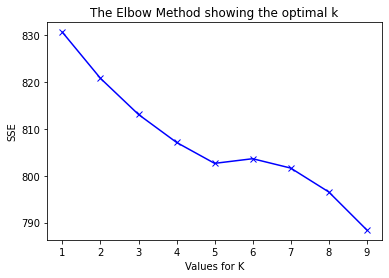

In [68]:
#Test increments of 100 clusters using elbow method
distortions = []
sse={}
K=range(1,10)
# for k in np.arange(100,900,100):
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(xTf)
    distortions.append(kmeans.inertia_)
    # sse[k] = kmeans.inertia_
# plt.plot(list(sse.keys()),list(sse.values()))
plt.plot(K,distortions,'bx-')
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#time 1m 35.7s

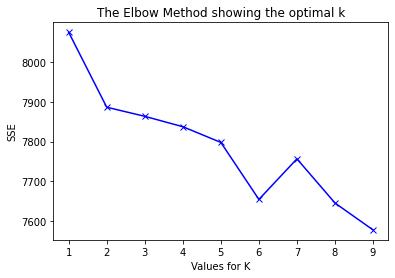

In [69]:
#Test increments of 100 clusters using elbow method
distortions = []
sse={}
K=range(1,10)
# for k in np.arange(100,900,100):
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(xBag)
    distortions.append(kmeans.inertia_)
    # sse[k] = kmeans.inertia_
# plt.plot(list(sse.keys()),list(sse.values()))
plt.plot(K,distortions,'bx-')
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

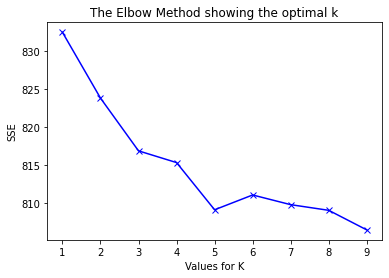

In [70]:
#Test increments of 100 clusters using elbow method
distortions = []
sse={}
K=range(1,10)
# for k in np.arange(100,900,100):
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(xNtf)
    distortions.append(kmeans.inertia_)
    # sse[k] = kmeans.inertia_
# plt.plot(list(sse.keys()),list(sse.values()))
plt.plot(K,distortions,'bx-')
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Create clusters

In [71]:
k=8
kModel=KMeans(n_clusters=k,init='k-means++', max_iter=10000, n_init=1)
kModel.fit(xTf)

KMeans(max_iter=10000, n_init=1)

In [72]:
indomain['Cluster']=kModel.labels_

indomain.head()

,tweet,subjectivity,tweetClus,Cluster
0,does canada have its own spy agency lol the...,subjective,does canada have its own spy agency lol the...,5
1,yes i dont want ya as james bond,subjective,yes i dont want ya as james bond,1
2,we all love ryan but hes canadian and inste...,subjective,we all love ryan but hes canadian and inste...,7
3,you woud make a great james bond but you wo...,subjective,you woud make a great james bond but you wo...,1
4,he looks like an agent or kingsman type of shi...,subjective,he looks like an agent or kingsman type of shi...,1


### Output results to a text file

In [73]:
# clusters= indomain.groupby('Cluster')

# for cluster in clusters.groups:
#     f=open('Cluster'+ str(cluster)+'.csv','w') #create csv file
#     data=clusters.get_group(cluster)[['tweet','subjectivity']] #get tweet & subjectivity columns
#     f.write(data.to_csv(index_label='id')) #set index to id
#     f.close()

## Understand what each cluster refers to

In [74]:
print('Cluster centroids: \n')
orderCentroids= kModel.cluster_centers_.argsort()[:,::-1]
terms=vectorizerTf.get_feature_names_out()

for i in range(k):
    print('Cluster %d:' %i)
    for j in orderCentroids[i, :10]: # print out 10 feature terms of each cluster
        print (' %s' %terms[j])
    print('-----------')

Cluster centroids: 

Cluster 0:
 restaurants
 ones
 denver
 takeout
 offering
 meals
 thanksgiving
 covid
 future
 friday
-----------
Cluster 1:
 bond
 james
 websiteisgiven
 wants
 007
 movie
 ryan
 holland
 tom
 new
-----------
Cluster 2:
 think
 good
 business
 world
 big
 actor
 state
 restaurant
 trailer
 pay
-----------
Cluster 3:
 great
 live
 restaurant
 music
 sales
 express
 panda
 fix
 slump
 wellknown
-----------
Cluster 4:
 restaurant
 websiteisgiven
 like
 dont
 movies
 need
 going
 life
 says
 chicken
-----------
Cluster 5:
 movie
 just
 im
 trilogy
 watching
 websiteisgiven
 love
 like
 trash
 theater
-----------
Cluster 6:
 new
 york
 study
 websiteisgiven
 university
 shawn
 yesterday
 killed
 jamesbond
 like
-----------
Cluster 7:
 yes
 lol
 098
 7910
 077
 right
 mean
 agree
 research
 hey
-----------


### Evaluating Clustering method

In [75]:
from sklearn.metrics import silhouette_score
silhouette_score(xTf, labels=kModel.predict(xTf))

0.007133252069057795

In [76]:
from sklearn.cluster import DBSCAN

dbClus = DBSCAN(eps=1, min_samples=2).fit(xTf)

In [77]:
indomain['DbCluster']=dbClus.labels_

indomain.head()

,tweet,subjectivity,tweetClus,Cluster,DbCluster
0,does canada have its own spy agency lol the...,subjective,does canada have its own spy agency lol the...,5,0
1,yes i dont want ya as james bond,subjective,yes i dont want ya as james bond,1,-1
2,we all love ryan but hes canadian and inste...,subjective,we all love ryan but hes canadian and inste...,7,0
3,you woud make a great james bond but you wo...,subjective,you woud make a great james bond but you wo...,1,0
4,he looks like an agent or kingsman type of shi...,subjective,he looks like an agent or kingsman type of shi...,1,0


In [78]:
clustUniq=np.unique(dbClus.labels_)
clustUniq

array([-1,  0,  1,  2,  3], dtype=int64)

In [79]:
print('Cluster centroids: \n')
# orderDbCentroids= dbClus.cluster_centers_.argsort()[:,::-1]
terms=vectorizerTf.get_feature_names_out()

for i in clustUniq:
    print('Cluster %d:' %i)
    for j in range(10): # print out 10 feature terms of each cluster
        print (' %s' %terms[j])
    print('-----------')

Cluster centroids: 

Cluster -1:
 000
 0069
 007
 007jamesbond
 007later
 007notimetodie
 00maple
 0500
 077
 098
-----------
Cluster 0:
 000
 0069
 007
 007jamesbond
 007later
 007notimetodie
 00maple
 0500
 077
 098
-----------
Cluster 1:
 000
 0069
 007
 007jamesbond
 007later
 007notimetodie
 00maple
 0500
 077
 098
-----------
Cluster 2:
 000
 0069
 007
 007jamesbond
 007later
 007notimetodie
 00maple
 0500
 077
 098
-----------
Cluster 3:
 000
 0069
 007
 007jamesbond
 007later
 007notimetodie
 00maple
 0500
 077
 098
-----------


In [80]:
from sklearn.metrics import silhouette_score
silhouette_score(xTf, labels=dbClus.fit_predict(xTf))

0.014350785806533149